# Clasificador Bayesiano "Ingenuo"

## Formalismo matemático

El clasificador bayesiano busca la probabilidad de la etiqueta $y$ dado el ejemplo $x$, es decir $P(y|x)$. Usando el teorema de Bayes podemos escribir esto como

$$
p(y | x) = \frac{p(x|y) p(y)}{p(x)} = \frac{p(x|y) p(y)}{\sum_{y\in\mathcal{Y}} p(x|y) p(y)}
$$

donde

- $p(y)$ es la probabilidad *a priori*, corresponde a lo que sabemos antes de observar el ejemplo
- $p(y|x)$ es la probabilidad *a posteriori*, corresponde a lo que sabemos luego de observar el ejemplo $x$
- $p(x|y)$ es la verosimilitud de observar un ejemplo con atributos $x$ suponiendo que la etiqueta es $y$

Si tenemos un problema de clasificación binario, es decir con dos etiquetas, podemos escribir

$$
\frac{p(y=1|x)}{p(y=0|x)} = \frac{p(x|y=1) p(y=1)}{p(x|y=0) p(y=0)}
$$

Si el cociente anterior es mayor que $1$ entonces la clase de $x$ es $1$, de lo contrario es $0$. Si tenemos un problema de clasificación con $C$ clases entonces decidimos la clase con

$$
\hat y = \text{arg}\max_{k=1,\ldots,C} p(x|y=k) p(y=k)
$$

En ambos casos el denominador del teorema de Bayes no se ocupa, pues es idéntico para todo $y$. Por otro lado el *prior* suele estimarse empíricamente a partir de la base de datos de entrenamiento como

$$
p(y=k) = \frac{\text{Cantidad de ejemplos con etiqueta k}}{\text{Cantidad de ejemplos}}
$$

En términos prácticos la principal ventaja de este clasificador es que es simple, fácil de entrenar y muy difícil de sobreajustar. Su mayor desventaja es que hace supuestos muy fuertes sobre los datos. Si no se cumplen el desempeño no será bueno. 


## Supuestos "ingenuos"

Sea $x$ un vector que representa $D$ atributos. El primer supuesto del clasificador bayesiano ingenuo es que los atributos **son independientes**. Por lo tanto la verosimilitud se puede escribir como

$$
p(x|y) = \prod_{d=1}^D p(x_d|y)
$$

En segundo lugar se debe suponer una distribución para los atributos. Por ejemplo si asumimos una distribución Gaussiana 

$$
p(x_d|y) = \mathcal{N}(\mu_d, \sigma_d^2)
$$

se tiene un clasificador bayesiano ingenuo con verosimilitud Gaussiana. Se pueden suponer otras distribuciones dependiendo de los datos

- La distribución Gaussiana es típicamente usada para atributos continuos
- Para atributos discretos se puede usar la distribución multinomial

## Ejemplo: Clasificación de biopsias

En este ejemplo implementaremos un clasificador bayesiano ingenuo con verosimilitud gaussiana y lo entrenaremos usando el dataset de [cancer de mama de la Universidad de Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). Para simplificar utilizaremos sólo dos atributos por paciente:

- x: radio de la muestra (valor continuo)
- z: textura de la muestra (valor continuo)

Adicionalmente la variable $y$ se refiere a la etiqueta de la muestra que puede ser benigno o maligno.

Importemos los datos y analicemos un gráfico de dispersión de los atributos. Reflexione ¿Son los datos separables?

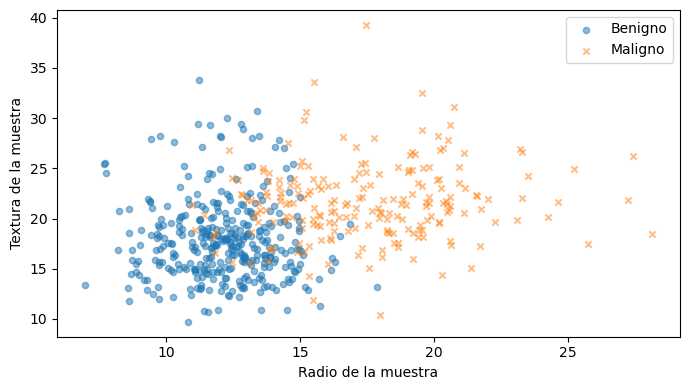

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

df = pd.read_csv('data/cancer.csv', index_col=0)
X, y = df.drop(columns="diagnosis").values, df["diagnosis"].replace({'M':1, 'B':0}). values

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(X[y==k, 0], X[y==k, 1], s=20, marker=marker, label=label, alpha=0.5)
ax.set_xlabel('Radio de la muestra')
ax.set_ylabel('Textura de la muestra')
plt.legend();

Al ser un problema de clasificación binaria podemos escribir

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} = \frac{p(x|y=1) p(z|y=1) p(y=1)}{p(x|y=0) p(z|y=0) p(y=0)}
$$

In [2]:
from collections import Counter

print(Counter(y))
py = [Counter(y)[i]/len(y) for i in range(2)]

Counter({0: 357, 1: 212})


El dataset tiene 569 pacientes, 212 con tumores malignos (1) y 357 tumores benignos (0).Con esta información estimamos los *priors*, es decir:

$$
p(y=1) = \frac{212}{569} \approx 0.41
$$

y

$$
p(y=0) = \frac{357}{569} \approx 0.59
$$

Ahora sólo falta encontrar los parámetros $\mu_x, \sigma_x, \mu_z, \sigma_z$. Los podemos encontrar aplicando el criterio de máxima verosimilitud sobre una distribución normal univariada mediante `scipy.stats.norm.fit`

In [3]:
import scipy.stats

dists = {}
for y_ in [0, 1]: # Para cada clase
    for d in [0, 1]: # para cada característica
        params = scipy.stats.norm.fit(X[y==y_, d])
        dists[(y_, d)] = scipy.stats.norm(loc=params[-2], scale=params[-1])

El siguiente gráfico de contornos muestra el resultado del ajuste para las distribuciones de los pacientes sanos y con cancer 

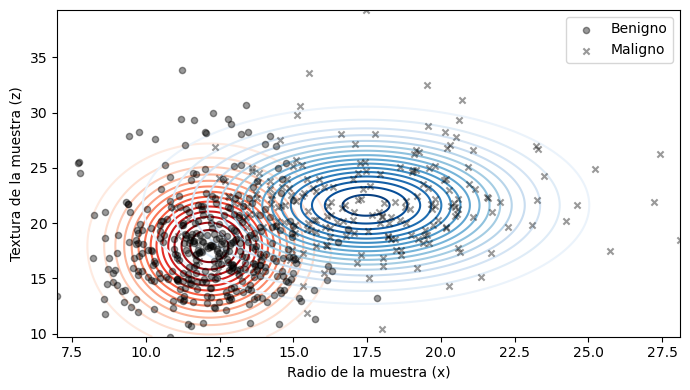

In [4]:
def verosimilitud_y_cociente(x, z):
    pxzy0 = dists[(0, 0)].pdf(x)*dists[(0, 1)].pdf(z)
    pxzy1 = dists[(1, 0)].pdf(x)*dists[(1, 1)].pdf(z)
    return pxzy0, pxzy1, (pxzy1*py[1])/(pxzy0*py[0] + 1e-8)

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(X[y==k, 0], X[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.4)

x_plot = np.linspace(np.amin(X[:, 0]), np.amax(X[:, 0]), num=500)
z_plot = np.linspace(np.amin(X[:, 1]), np.amax(X[:, 1]), num=500)

X_2d, Z_2d = np.meshgrid(x_plot, z_plot)
Y_2d = verosimilitud_y_cociente(X_2d, Z_2d)
ax.contour(X_2d, Z_2d, Y_2d[0], zorder=-1, cmap=plt.cm.Reds, levels=20)
ax.contour(X_2d, Z_2d, Y_2d[1], zorder=-1, cmap=plt.cm.Blues, levels=20)
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
ax.set_xlabel('Radio de la muestra (x)')
ax.set_ylabel('Textura de la muestra (z)')
plt.legend();

El último paso consiste en decidir entre benigno y maligno usando el cociente entre los posterior

En el caso binario es típico usar una regla como la siguiente

$$
\frac{p(y=1|x, z)}{p(y=0|x, z)} > R
$$

donde $R$ es un "umbral de clasificación". El siguiente gráfico muestra las fronteras de decisión usando cuatro umbrales distintos

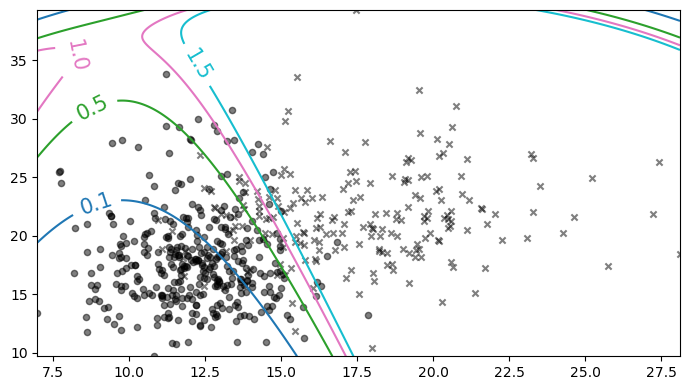

In [5]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Benigno', 'Maligno'], ['o', 'x'])):
    ax.scatter(X[y==k, 0], X[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.5)

cp = ax.contour(X_2d, Z_2d, Y_2d[2] , levels=[0.1, 0.5, 1., 1.5], cmap=plt.cm.tab10);
ax.clabel(cp, fontsize=15, fmt='%0.1f', manual=[(9.0, 35), (9.0, 30), (9.0, 22), (12.5, 35)]);

Podemos "ajustar" el riesgo $R$ para controlar el compromiso (trade-off) entre los siguientes tipos de errores

1. Falso positivo: Predecir que el paciente está enfermo $\hat y=1$ cuando en realidad estaba sano $y=0$
1. Falso negativo: Predecir que el paciente está sano $\hat y=0$ cuando en realidad estaba enfermo $y=1$

Reflexione: En un problema de índole médico como el que acabamos de revisar ¿Cuáles son las repercusiones de cada uno de estos errores? ¿Cuál es más grave?

## Clasificador bayesiano con  `scikit-learn`

A continuación se utiliza el módulo [`sklearn.naive_bayes`](https://scikit-learn.org/stable/modules/naive_bayes.html) que implementa distintos clasificadores bayesianos ingenuos, entre ellos

- Clasificador con verosimilitud Gaussiana: `GaussianNB`
- Clasificador con verosimilitud Multinomial: `MultinomialNB`

Por ejemplo el constructor de `GaussianNB` es

```python
sklearn.naive_bayes.GaussianNB(priors=None, # Un ndarray con las probabilidades a priori
                               ...
                              )
```

:::{note}

Si los priors no se especifican se estiman desde la etiqueta al momento de llamar el método `fit`

:::

cuyos métodos más importantes son

- `fit(X, y)`: Ajusta el modelo a un conjunto de datos `X` con etiqueta `y`
- `predict_proba(X)`: Retorna la probabilidad de cada clase
- `predict(X)`: Retorna la clase de máxima probabilidad
- `score(X, y)`: Retorna la exactitud (*accuracy*) promedio del modelo



Usemos lo aprendido para entrenar el clasificador bayesiano en los datos del ejemplo anterior

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB(priors=py) #Usamos los priors calculados antes
clf.fit(X[:, :2], y) # Entrenamos

GaussianNB(priors=[0.6274165202108963, 0.37258347978910367])

Podemos uar el método `predict_proba` para visualizar la frontera de decisión

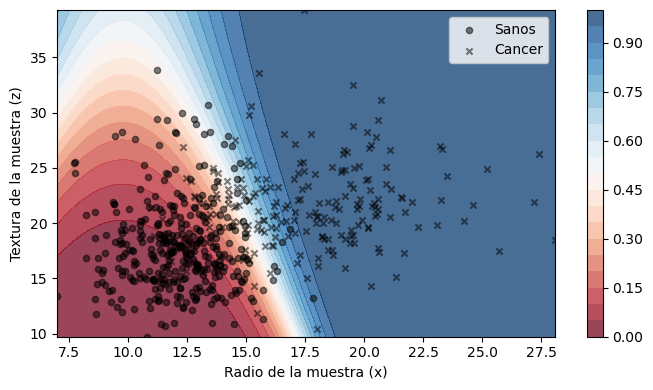

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
for k, (label, marker) in enumerate(zip(['Sanos', 'Cancer'], ['o', 'x'])):
    ax.scatter(X[y==k, 0], X[y==k, 1], c='k', s=20, 
               marker=marker, label=label, alpha=0.5)

Y_2d = clf.predict_proba(np.stack((X_2d.ravel(), Z_2d.ravel())).T)[:, 1]
#Y = clf.predict(np.stack((X.ravel(), Z.ravel())).T)

cf = ax.contourf(X_2d, Z_2d, np.reshape(Y_2d, X_2d.shape), 
                 zorder=-1, cmap=plt.cm.RdBu, vmin=0, vmax=1, levels=20, alpha=0.75)
ax.set_xlim([np.amin(x_plot), np.amax(x_plot)])
ax.set_ylim([np.amin(z_plot), np.amax(z_plot)])
ax.set_xlabel('Radio de la muestra (x)')
ax.set_ylabel('Textura de la muestra (z)')
plt.colorbar(cf)
plt.legend();

En la próxima lección veremos como evaluar el desempeño de nuestro clasificador entrenado